In [2]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

start=datetime(2023,6,1)
end=datetime(2023,8,31)
location=Point(48.864716,2.349014,35)
data=Daily(location,start,end)
data=data.fetch()

In [3]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2023-06-01,21.2,14.8,27.5,0.0,NaN,36.0,15.7,41.0,1018.7,NaN
2023-06-02,16.3,11.1,22.0,0.0,NaN,31.0,18.7,42.0,1019.3,NaN
2023-06-03,19.1,12.0,25.5,0.0,NaN,39.0,13.5,39.0,1017.7,NaN
2023-06-04,21.1,14.4,26.9,0.0,NaN,41.0,15.0,41.0,1018.0,NaN
2023-06-05,20.6,13.8,26.8,0.0,NaN,31.0,15.2,44.0,1018.4,NaN


In [4]:
data.tail()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2023-08-27,16.9,13.7,20.7,0.0,NaN,296.0,9.0,35.0,1012.8,NaN
2023-08-28,16.9,14.1,20.8,0.2,NaN,322.0,8.9,33.0,1014.2,NaN
2023-08-29,17.5,14.1,21.0,0.1,NaN,325.0,8.0,31.0,1013.6,NaN
2023-08-30,17.1,14.0,20.2,0.2,NaN,275.0,9.8,42.0,1010.7,NaN
2023-08-31,16.9,14.3,19.1,5.2,NaN,219.0,8.7,39.0,1012.9,NaN


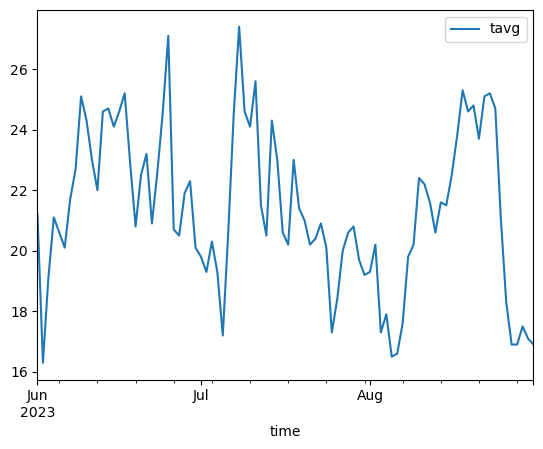

In [5]:
data.plot(y=['tavg'])
plt.show()

In [11]:
y = np.array(data['tavg'])
x = np.arange((len(data['tavg'])))

In [17]:
import pandas as pd
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import norm,normaltest,probplot
from scipy import optimize
from matplotlib import style
from statistics import pstdev
import pylab 

In [18]:
def form(x,A,B,C,phi):
    return A + B * x + C * np.sin(np.radians(x - phi))


In [19]:
param, covariance = optimize.curve_fit(form, x, y, [0, 0, 0, 0])
fit_cosin = form(x, *param)

In [26]:
projection_mean = y - fit_cosin 

b :  0.7392697298560662
a :  -0.03371158336931525
se :  11.567436971881492


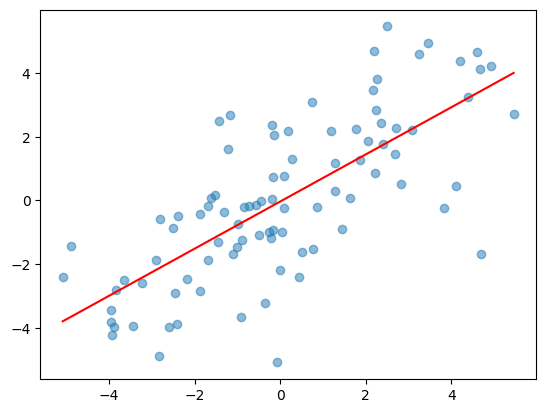

In [36]:
absc = projection_mean[:-1].reshape((-1, 1))
ordo = projection_mean[1:]
model = LinearRegression(fit_intercept=True)
model.fit(absc, ordo)
b = model.coef_[0]
a = model.intercept_
x_test=np.linspace(min(absc[:-1]),max(absc[:-1]),num=len(absc)).reshape((-1, 1))
y_pred = model.predict(x_test)

se = mean_squared_error(ordo, y_pred)
print("b : ",b)
print("a : ", a)
print("se : ", se)

plt.scatter(absc,ordo,alpha=0.5)
plt.plot(x_test,y_pred,c="red")
plt.show()

In [37]:
K = -np.log(b)
theta = a/(1-b)
sigma = se*np.sqrt(-2*np.log(b)/(1-b**2))/10

In [38]:
def OU(x,t,K,theta,sigma):
    res=[x]
    for i in range(t):
        ou_t = res[-1]*np.exp(-K)+theta*(1-np.exp(-K))+sigma*np.sqrt((1-np.exp(-2*K))/(2*K))*np.random.normal(0,1)
        res.append(ou_t)
    return np.array(res)

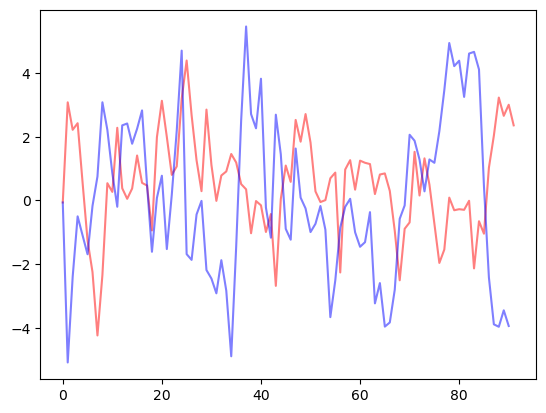

In [39]:
res= OU(projection_mean[0],len(projection_mean)-1,K,theta,sigma)
plt.plot(res,alpha=0.5,c="red")
plt.plot(projection_mean[:-1],alpha=0.5,c="blue")
plt.show()

In [40]:
def pred_T(n,x0,t0):
    new_x = np.array([x0+i for i in range(N)])
    fit_cosin_future = form(new_x, *param)
    ou_test= OU(projection_mean[-1],n-1,K,theta,sigma)
    temprerature_prediction = fit_cosin_future + ou_test
    return temprerature_prediction

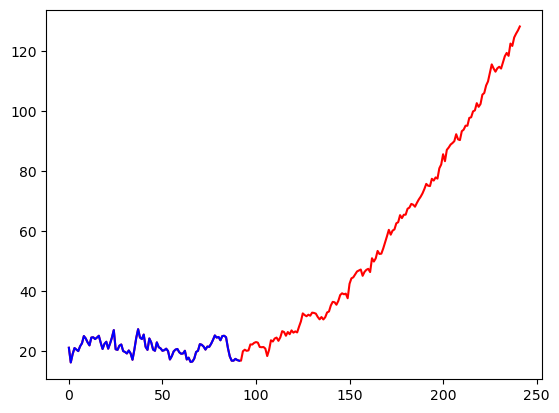

In [41]:
N = 30 * 5
temprerature_prediction = pred_T(N, x[-1], y[-1])
plt.plot([i for i in range(len(x) + N)],list(y) + list(temprerature_prediction),c="red")
plt.plot(x,y,c="blue")
plt.show()

In [42]:
referential =y[-1]

In [43]:
def H(n,x0,t0):
    return (referential  *n - np.sum(pred_T(n,x0,t0)))

In [44]:
n_sim=100
sim = np.array([H(N,x[-1],y[-1]) for i in range(n_sim)])

In [45]:
mu_n = np.mean(sim)
sigma_n=pstdev(sim)
print("mu_n : ",mu_n)
print("sigma_n : ",sigma_n)

mu_n :  -6572.699285295939
sigma_n :  52.39245900464303


In [51]:
r = 0.05/365
def call_cdd(t, strike, r):
    return( np.exp(- r  *t) * ((strike-mu_n) * (norm.cdf(alpha_n)-norm.cdf(-mu_n/sigma_n)) + sigma_n/np.sqrt(2 * np.pi)*(np.exp(-0.5*sigma_n**2)-np.exp(-0.5*(mu_n/sigma_n)**2))))

In [52]:
strike_array = np.linspace(0, 1000, num=10000)

In [53]:
prime_aray = []
for strike in strike_array:
    alpha_n = (strike - mu_n)/sigma_n
    print("alpha_n : ", alpha_n)
    print("N : ", N)
    print("mu_n", mu_n)
    prime_aray.append(call_cdd(N, strike, r))
    print("CALL CDD Strike ", strike, " : ", prime_aray[-1])

alpha_n :  125.45124642295308
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.0  :  0.0
alpha_n :  125.45315528546686
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.1000100010001  :  0.0
alpha_n :  125.45506414798068
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.2000200020002  :  0.0
alpha_n :  125.45697301049448
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.3000300030003  :  0.0
alpha_n :  125.4588818730083
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.4000400040004  :  0.0
alpha_n :  125.4607907355221
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.5000500050005  :  0.0
alpha_n :  125.46269959803591
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.6000600060006  :  0.0
alpha_n :  125.46460846054971
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.7000700070007  :  0.0
alpha_n :  125.46651732306353
N :  150
mu_n -6572.699285295939
CALL HDD Strike  0.8000800080008  :  0.0
alpha_n :  125.46842618557731
N :  150
mu_n -6572.699285295939
CALL HDD Strike

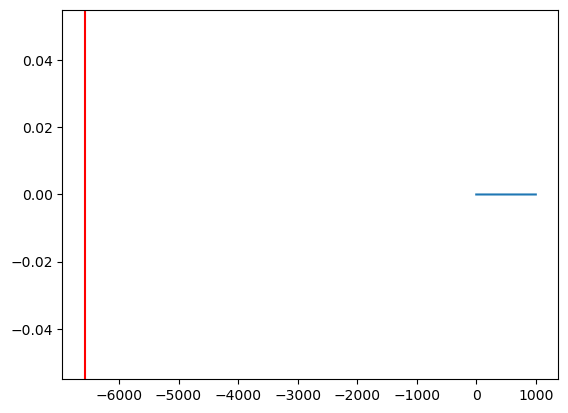

In [54]:
plt.plot(strike_array, prime_aray)
plt.axvline(mu_n, c="red")
plt.show()